# Naive Bayes Document Classification

Naive Bayes, with its independent assumptions is particularly well suited for
Text Processing applications where the large dimmentionality of the feature space makes more sofisticated methods challenging to apply.

We will use again the Reuters `C50` text corpus for our analysis. 


## Preliminaries

### Imports

In [1]:
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

import sys
sys.path.append("../..")
from E4525_ML import plots

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

### Data Directories

In [2]:
raw_data_dir=r"../../raw/C50/C50train"
test_dir    =r"../../raw/C50/C50test"
data_dir=r"../../data/C50"


## Document Data

### Corpus (List of documents)

In [3]:
documents_filename=data_dir+"/C50_documents.csv"
documents=pd.read_csv(documents_filename,index_col="document_id")
Y=documents["label"]
documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50train/AaronPressman/106247new...,AaronPressman
1,../../raw/C50/C50train/AaronPressman/120600new...,AaronPressman
2,../../raw/C50/C50train/AaronPressman/120683new...,AaronPressman
3,../../raw/C50/C50train/AaronPressman/136958new...,AaronPressman
4,../../raw/C50/C50train/AaronPressman/137498new...,AaronPressman


In [4]:
test_documents_filename=data_dir+"/C50_test_documents.csv"
test_documents=pd.read_csv(test_documents_filename,index_col="document_id")
Y_test=test_documents["label"]
test_documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50test/AaronPressman/421829news...,AaronPressman
1,../../raw/C50/C50test/AaronPressman/424074news...,AaronPressman
2,../../raw/C50/C50test/AaronPressman/42764newsM...,AaronPressman
3,../../raw/C50/C50test/AaronPressman/43033newsM...,AaronPressman
4,../../raw/C50/C50test/AaronPressman/433558news...,AaronPressman


### Load Pre-Trained Features

#### Set Features

In [5]:
set_features_filename=data_dir+"/"+"set_features.p"
set_features=pickle.load(open(set_features_filename,"rb"))

In [6]:
set_test_features_filename=data_dir+"/"+"set_test_features.p"
set_test_features=pickle.load(open(set_test_features_filename,"rb"))

#### Count Features

In [7]:
count_features_filename=data_dir+"/"+"count_features.p"
count_features=pickle.load(open(count_features_filename,"rb"))

In [8]:
count_test_features_filename=data_dir+"/"+"count_test_features.p"
count_test_features=pickle.load(open(count_test_features_filename,"rb"))

#### TF-IDF Features

In [9]:
tfidf_features_filename=data_dir+"/"+"tfidf_features.p"
tfidf_features=pickle.load(open(tfidf_features_filename,"rb"))

In [10]:
tfidf_test_features_filename=data_dir+"/"+"tfidf_test_features.p"
tfidf_test_features=pickle.load(open(tfidf_test_features_filename,"rb"))

## Naive Bayes Implementation

With represent a document $i$ as $X_{i,d}$ the vector of counts for each word $d=1,\cdots, V$ where $V$ is the corpus vocabulary size.

If document classes belong to the set $k=1,\cdots K$, where $K$ is the number of classes  we  can represent the document labels as a $Z_{i,k}$ one-hot encoded variable
($Z_{i,k}=1$ if document $i$ belongs to class $k$, zero otherwise.

With this representation, $n_{k,d}$ the number of times that word $d$ appears in documents on class $k$ can be expressed as 
$$
    n_{k,d} = \sum_i Z_{i,k} X_{i,d} = Z^T X
$$
and $n_k$ the total number of words   in class $k$ is
$$
    n_k = \sum_d n_{k,d}
$$
    

Let's collect our inputs and labels

In [11]:
X=count_features
X_test=count_test_features
Y.shape,X.shape

((2500,), (2500, 28060))

And define our $Z_{i,k}$ dummy variables

In [12]:
dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
labels=dummies.columns
Z=dummies.to_coo() # Most entries are zero, so we want Z represented as a sparse matrix
             # if you remove this line, calculations become very slow
print(Z.shape)

(2500, 50)


And we can compute $n_{k,d}$ the word counts as a vector product

In [13]:
word_counts=Z.T.dot(X)
word_counts.shape

(50, 28060)

And $n_k$ as the sum over all words in class $k$

In [14]:
class_word_counts=word_counts.sum(axis=1)
print(class_word_counts.shape)

(50, 1)


We set $\alpha$ the Laplace smoothing parameter, and $V$, the vocabulary size

In [15]:
alpha=0.5
V=X.shape[1] # Vocabulary size
print("alpha = ",alpha)
print("V     = ",V)

alpha =  0.5
V     =  28060


the **Naive Bayes weigths** are given by
$$
    w_{k,d} = \log \frac{ \alpha+n_{k,d} }{ \alpha V+n_{k} }
$$

In [16]:
# can not add a constant to a sparse matrix, so we need to 
# transform the word_counts into a dense numpy matrix
word_counts=word_counts.todense()
w=np.log((alpha+word_counts)/(class_word_counts+alpha*V))
w.shape

(50, 28060)

In the Naive Bayes approximation the log probability of single new document represented by the counts vector $x_d$ belongs to class $k$ is given by
$$
    l_k = b_k+\sum_d x_d w_{k,d}
$$
where, $b_k$ are the *a priori* log probabilities of each document class which can be estimated from the corpus class labels as
$$
    b_k = \log \frac{1}{N}\sum_i Z_{i,k}
$$

For a collection of $N$ documents represented by count matrix $X_{i,d}$ this formula becomes
$$
    l_{i,k} = b_k+\sum_d X_{i,d} w_{k,d}
$$
or, in matrix notation:
$$
    L = b+X \cdot W^T
$$
where $L$ is the $N \times K$ matrix of class probabilities for each document and $b$ is the $K$-dimensional vector of *a priori* class probabilities.

In [17]:
L=X_test[48:53].dot(w.T)

Finally we select the class $Y_i$ of a document as 
$$
    Y_i = \underset{k}{\operatorname{argmax}} L_{i,k}
$$

In [18]:
Y_pred=L.argmax(axis=1) 
Y_pred=Y_pred.ravel() # numpy returns a Nx1 matrix , but we want a numpy N vector


We collect this calculations into an easy to use implementation

In [19]:
class NaiveBayes:
    def __init__(self,alpha):
        self.alpha=alpha
        
    def fit(self,X,Y):
        V=X.shape[1]
        dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
        self.classes=dummies.columns
        Z=dummies.to_coo()
        word_counts=Z.T.dot(X).todense()
        class_word_counts=word_counts.sum(axis=1)
        self.b=np.log(Z.sum(axis=0)/Z.sum())
        self.w=np.log((self.alpha+word_counts)/(self.alpha*V+class_word_counts))
    def predict(self,X):
        L=self.b+X.dot(self.w.T)
        Y_pred=L.argmax(axis=1)
        return np.array(self.classes[Y_pred]).ravel()

### Test of Implemenation

We select a few test documents to test

In [20]:
x=X_test[48:153]
y=Y_test[48:153]

In [21]:
alpha=1
model=NaiveBayes(alpha)
model.fit(X,Y)
Y_pred=model.predict(x)
np.average(Y_pred==y)


0.49523809523809526

### Comparison to `Sklearn` implementation

In [22]:
sk_model=MultinomialNB(alpha=alpha)

In [23]:
sk_model.fit(X,Y)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [24]:
y_pred=sk_model.predict(x)
np.average(y_pred==y)

0.49523809523809526

## Full Test Corpus Evaluation

### In sample performance 

In [25]:
model=NaiveBayes(alpha)
model.fit(X,Y)
Y_pred=model.predict(X)
np.average(Y_pred==Y)


0.96760000000000002

### Out of Sample performance

In [26]:
Y_pred=model.predict(X_test)
np.average(Y_pred==Y_test)

0.65000000000000002

In [27]:
sk_model=MultinomialNB(alpha=alpha)
sk_model.fit(X,Y)
Y_pred=sk_model.predict(X_test)
np.average(Y_pred==Y_test)

0.65000000000000002

### Confusion Matrix 

We could use the confusion matrix to understand the  kind of errors that the model makes

In [28]:
classes=np.unique(Y.as_matrix())

Confusion matrix, without normalization
[[44  0  0 ...,  0  0  0]
 [ 0 23  0 ...,  0  0  0]
 [ 0  0 26 ...,  0  0  0]
 ..., 
 [ 0  0  2 ..., 40  0  0]
 [ 0  0  0 ...,  0 22  0]
 [ 0  0  0 ...,  0  0 14]]


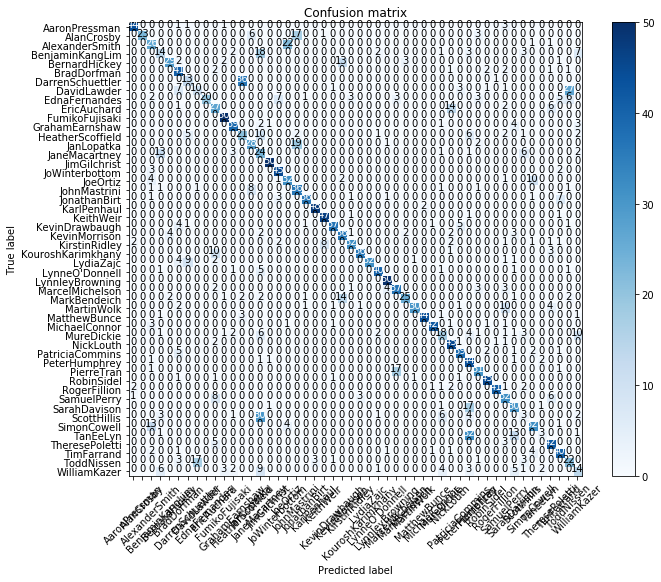

In [29]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)

## TF-IDF Features Implementation of Naive-Bayes

As we have represented Naive Bayes as a set of matrix multiplications operating over the
document feature vector, we can naturally extend its implementation to any other feature vector.

For example we can implement Naive Bayes using the **TF-IDF** feature vector

In [30]:
Xi=tfidf_features
Xi_test=tfidf_test_features

It performs slighly worse that on counts, but this is problem dependent.

In [31]:
model.fit(Xi,Y)
Y_pred=model.predict(Xi_test)
np.average(Y_pred==Y_test)

0.63480000000000003

## Set Features Implementatio of Naive-Bayes

In [32]:
X_set=set_features
X_set_test=set_test_features

In [33]:
model.fit(X_set,Y)
Y_pred=model.predict(X_set_test)
np.average(Y_pred==Y_test)

0.65839999999999999